In [13]:

import torch

from e2cnn import gspaces
from e2cnn import nn

from matplotlib import pyplot as plt

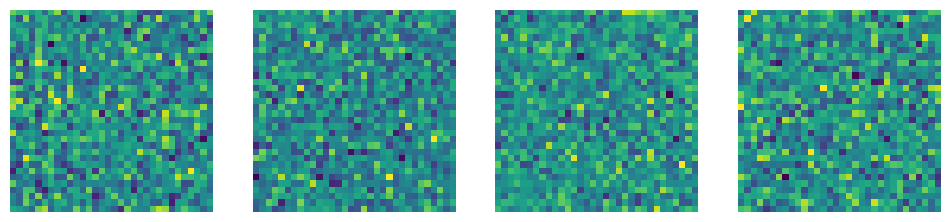

In [18]:
r2_act = gspaces.Rot2dOnR2(N=4)
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_out = nn.FieldType(r2_act, 3*[r2_act.regular_repr])
conv = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)
x = torch.randn(4, 1, 32, 32)
x = nn.GeometricTensor(x, feat_type_in)

assert isinstance(x.tensor, torch.Tensor)

y = conv(x)
assert y.type == feat_type_out


def plot_tensor(tensor):
    n_batch = tensor.shape[0]
    fig, axs = plt.subplots(1, n_batch, figsize=(12, 3))
    for i in range(n_batch):
        axs[i].imshow(tensor[i, 0].detach().numpy())
        axs[i].axis('off')
    plt.show()

plot_tensor(x.tensor)

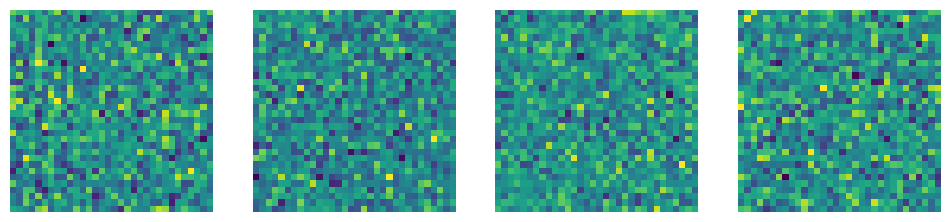

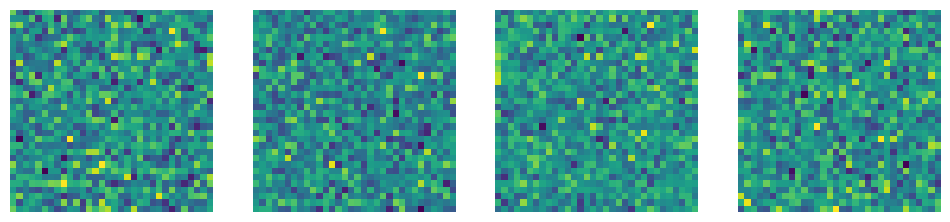

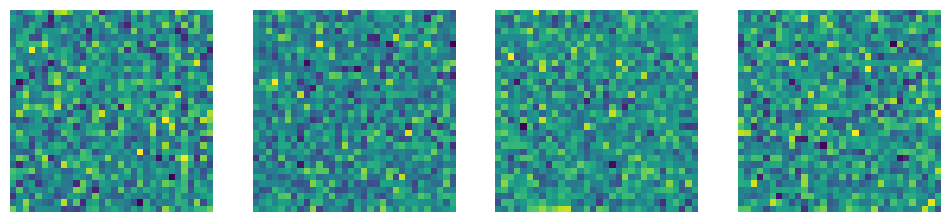

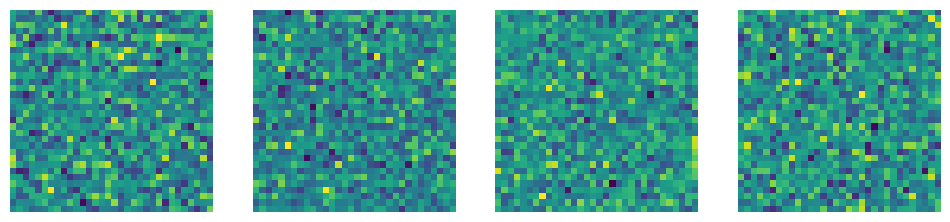

In [19]:

# for each group element
for g in r2_act.testing_elements:
    # transform the input with the current group element according to the input type
    x_transformed = x.transform(g)
    plot_tensor(x_transformed.tensor)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = conv(x_transformed)
    
    # the result should be equivalent to rotating the output produced in the 
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g



In [9]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()